In [107]:
import yfinance as yf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize

# 1. Data Importation

In [108]:
tickers = ['AAPL', 'XOM', 'JNJ', 'TSLA']
n = len(tickers)
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start="2020-01-01", end="2025-01-01")

/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_97653/547112229.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  4 of 4 completed


In [109]:
data = data['Close']

In [110]:
print(data.head())

Ticker           AAPL         JNJ       TSLA        XOM
Date                                                   
2020-01-02  72.620819  124.983688  28.684000  54.634781
2020-01-03  71.914818  123.536636  29.534000  54.195564
2020-01-06  72.487846  123.382568  30.102667  54.611679
2020-01-07  72.146942  124.136017  31.270666  54.164722
2020-01-08  73.307503  124.118896  32.809334  53.347900


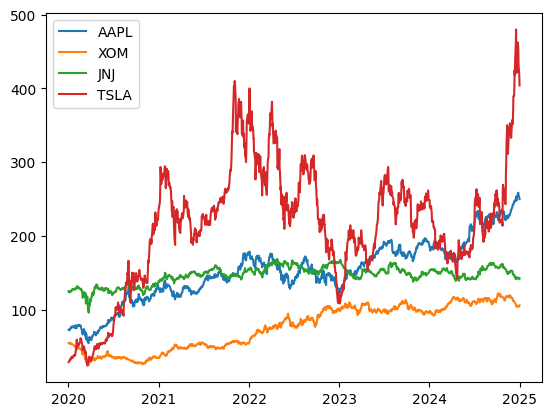

In [111]:
for ticker in tickers :
    plt.plot(data[ticker], label=ticker)

plt.legend()
plt.show()

In [112]:
log_returns = (data / data.shift(1)).apply(lambda x: np.log(x)).dropna()

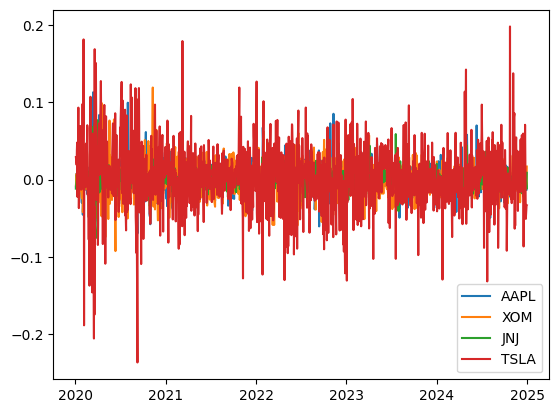

In [113]:
for ticker in tickers :
    plt.plot(log_returns[ticker], label=ticker)

plt.legend()
plt.show()

In [114]:
mean_returns = log_returns.mean() * 252  

cov_matrix = log_returns.cov() * 252

In [115]:
print(f'Mean returns : {mean_returns}')
print(f'Covariance matrix : {cov_matrix}')

Mean returns : Ticker
AAPL    0.247685
JNJ     0.025945
TSLA    0.530198
XOM     0.132194
dtype: float64
Covariance matrix : Ticker      AAPL       JNJ      TSLA       XOM
Ticker                                        
AAPL    0.100198  0.023279  0.104444  0.031365
JNJ     0.023279  0.038475  0.011320  0.020327
TSLA    0.104444  0.011320  0.448889  0.035068
XOM     0.031365  0.020327  0.035068  0.118258


# 2. Portfolio Simulation

In [116]:
m = 30000 # nombre de portefeuilles simulés
rf = 0.03 # risk free rate of return

In [117]:
randoms = np.random.rand(m,n)
weights = randoms / randoms.sum(axis=1, keepdims=True)

In [118]:
weights

array([[0.20041479, 0.22606139, 0.20082723, 0.37269658],
       [0.24622839, 0.1691436 , 0.29531153, 0.28931648],
       [0.08024855, 0.39950885, 0.03324605, 0.48699656],
       ...,
       [0.39405401, 0.08213311, 0.3660339 , 0.15777898],
       [0.14233692, 0.27980675, 0.07066336, 0.50719298],
       [0.01784827, 0.38088422, 0.41206166, 0.18920585]], shape=(30000, 4))

In [119]:
mu = []
sigma = []
sharpe_ratio = []

for i in range(weights.shape[0]):
    port_return = np.dot(weights[i], mean_returns)

    port_vol = np.sqrt(np.dot(weights[i], np.dot(cov_matrix, weights[i])))

    mu.append(port_return)
    sigma.append(port_vol)
    
    sharpe_ratio.append((port_return-rf)/port_vol)

In [120]:
portfolios = pd.DataFrame(data = {'Return':mu,'Volatility':sigma,'Sharpe Ratio':sharpe_ratio})

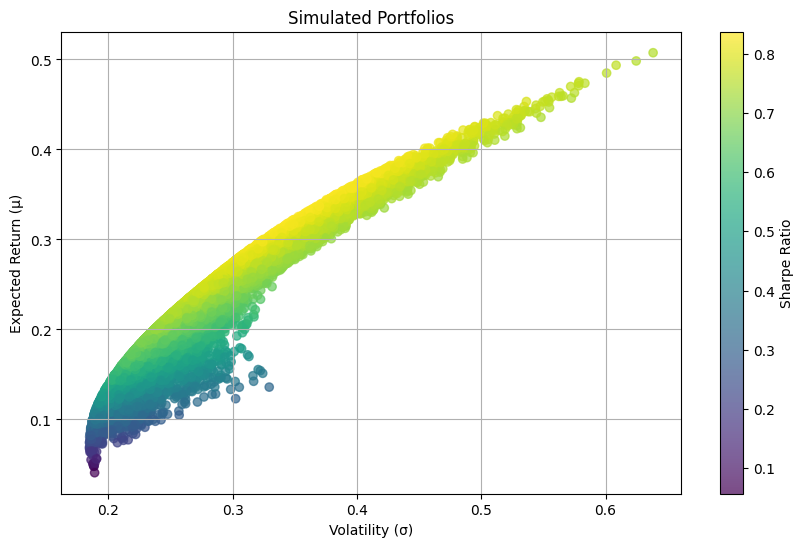

In [121]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios['Volatility'],
    portfolios['Return'],
    c=portfolios['Sharpe Ratio'],
    cmap='viridis',  
    alpha=0.7
)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Simulated Portfolios')
plt.grid(True)
plt.show()

# 3. Efficient Frontier

In [122]:
target_returns = np.linspace(portfolios['Return'].min(),portfolios['Return'].max(),100)

In [123]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights, np.dot(cov_matrix, weights))

def constraint_sum_to_one(weights):
    return np.sum(weights) - 1

def constraint_target_return(weights, mean_returns, target_return):
    return np.dot(weights, mean_returns) - target_return

x0 = np.ones(n) / n

bounds = tuple((0, 1) for _ in range(n))

weights = []
returns = []
vol = []

for i in range(len(target_returns)):
    constraints = [
        {'type': 'eq', 'fun': constraint_sum_to_one},
        {'type': 'eq', 'fun': constraint_target_return, 'args': (mean_returns, target_returns[i])}
    ]

    result = minimize(
        fun=portfolio_variance,
        x0=x0,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    opt_weights = result.x

    weights.append(opt_weights)
    returns.append(np.dot(opt_weights, mean_returns))
    vol.append(np.sqrt(portfolio_variance(opt_weights, cov_matrix)))

efficient_frontier = pd.DataFrame(data = {'weights':weights, 'returns':returns, 'volatility':vol})

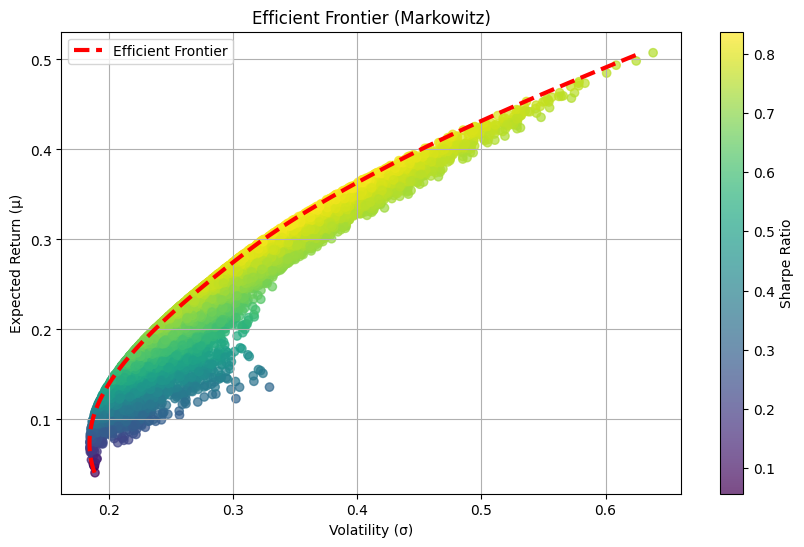

In [124]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios['Volatility'],
    portfolios['Return'],
    c=portfolios['Sharpe Ratio'],
    cmap='viridis',  
    alpha=0.7
)
plt.plot(efficient_frontier['volatility'], efficient_frontier['returns'], 'r--', linewidth=3, label='Efficient Frontier')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Efficient Frontier (Markowitz)')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.show()

# 4. Minimal Variance Portfolio

In [125]:
constraints = [
    {'type': 'eq', 'fun': constraint_sum_to_one},
]

result = minimize(
    fun=portfolio_variance,
    x0=x0,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

min_var_weights = result.x
min_var_return = np.dot(min_var_weights,mean_returns)
min_vol = np.sqrt(np.dot(min_var_weights,np.dot(cov_matrix,min_var_weights)))

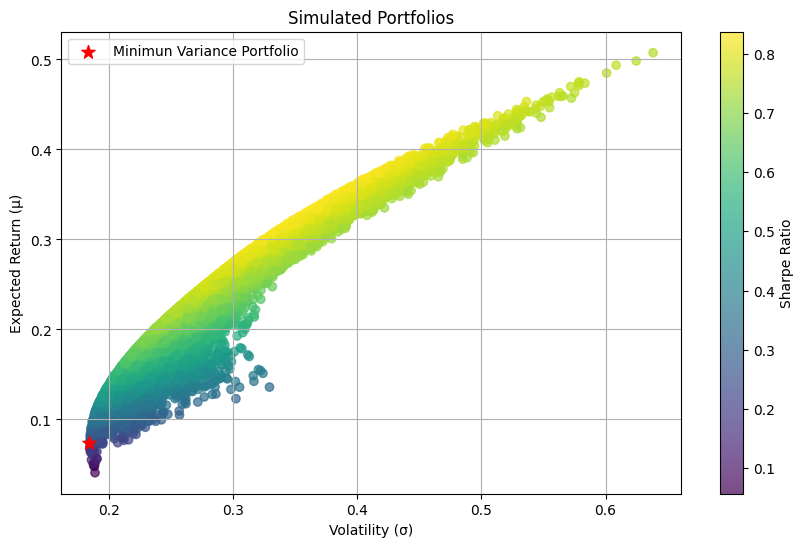

In [126]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios['Volatility'],
    portfolios['Return'],
    c=portfolios['Sharpe Ratio'],
    cmap='viridis',  
    alpha=0.7
)
plt.scatter(min_vol,min_var_return, label='Minimun Variance Portfolio', c='red', marker='*', s=100)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Simulated Portfolios')
plt.grid(True)
plt.legend()
plt.show()

# 5. Tangent Portfolio

In [127]:
import numpy as np
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights, np.dot(cov_matrix, weights))

def constraint_sum_to_one(weights):
    return np.sum(weights) - 1

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(portfolio_variance(weights, cov_matrix))
    return -(port_return - rf) / port_vol

x0 = np.ones(n) / n
bounds = tuple((0, 1) for _ in range(n))

constraints = [{'type': 'eq', 'fun': constraint_sum_to_one}]

result = minimize(
    fun=neg_sharpe_ratio,
    x0=x0,
    args=(mean_returns, cov_matrix, rf),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weights = result.x
opt_return = np.dot(opt_weights, mean_returns)
opt_vol = np.sqrt(portfolio_variance(opt_weights, cov_matrix))
opt_sharpe = (opt_return - rf) / opt_vol


print("Tangent Portfolio:")
print("Weights:", opt_weights)
print("Return:", opt_return)
print("Volatility:", opt_vol)
print("Sharpe Ratio:", opt_sharpe)

Tangent Portfolio:
Weights: [0.53115976 0.         0.34221159 0.12662865]
Return: 0.32974010561514877
Volatility: 0.35771753109773224
Sharpe Ratio: 0.8379240030404228


# 6. Final Representation

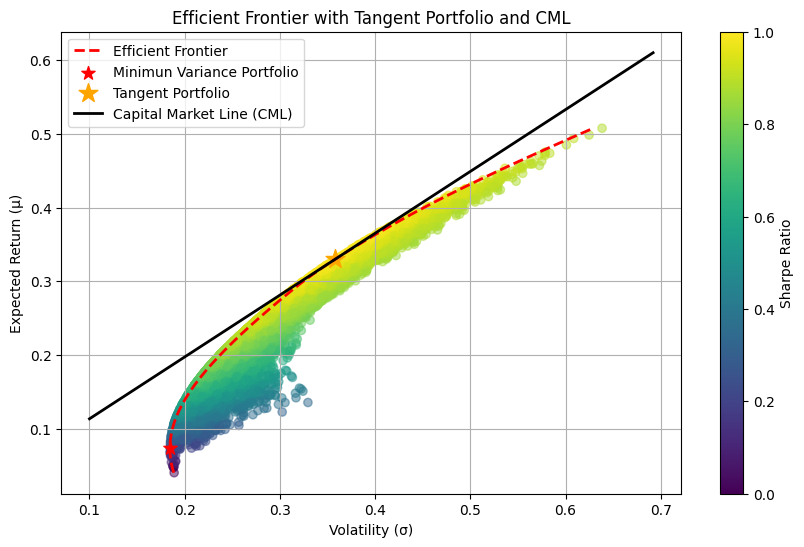

In [130]:

cml_vol = np.linspace(0.1, max(efficient_frontier['volatility']) * 1.1, 100)
cml_return = rf + opt_sharpe * cml_vol 

plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe Ratio'], cmap='viridis', alpha=0.5)

plt.plot(efficient_frontier['volatility'], efficient_frontier['returns'], 'r--', linewidth=2, label='Efficient Frontier')

plt.scatter(min_vol,min_var_return, label='Minimun Variance Portfolio', c='red', marker='*', s=100)

plt.scatter(opt_vol, opt_return, color='orange', marker='*', s=200, label='Tangent Portfolio')

plt.plot(cml_vol, cml_return, 'k-', linewidth=2, label='Capital Market Line (CML)')

plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Efficient Frontier with Tangent Portfolio and CML')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.show()
